In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv('/content/employee_promotion.csv')

In [3]:
data

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,56.0,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,0,79.0,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,NaN,0


In [4]:
data.drop(['employee_id'], axis =1, inplace = True
          )

In [5]:
data.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

In [6]:
X = data.drop(['is_promoted'], axis =1)
y= data.is_promoted

In [11]:
X.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
awards_won                 0
avg_training_score         0
dtype: int64

In [13]:
X.education.fillna("Bachelor's", inplace = True)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 20)


In [15]:
x_train.isna().sum()



department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won              0
avg_training_score      0
dtype: int64

In [16]:
num_features = x_train.select_dtypes(exclude = "object")
cat_features = x_train.select_dtypes(include = "object")

In [17]:
num_features


,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
22770,1,55,5.0,4,0,68.000000
17174,2,40,3.0,8,0,48.000000
25924,1,42,5.0,6,0,82.000000
19407,2,37,5.0,7,0,63.712238
29850,1,29,4.0,5,0,79.000000
...,...,...,...,...,...,...
23452,1,36,3.0,8,0,58.000000
23775,2,26,4.0,4,0,85.000000
37135,1,38,3.0,3,0,58.000000
27098,1,27,4.0,4,0,60.000000


In [18]:
cat_features

,department,region,education,gender,recruitment_channel
22770,Procurement,region_2,Master's & above,f,referred
17174,Sales & Marketing,region_27,Bachelor's,m,sourcing
25924,Analytics,region_2,Master's & above,f,sourcing
19407,Operations,region_22,Master's & above,m,other
29850,Technology,region_13,Bachelor's,f,other
...,...,...,...,...,...
23452,Legal,region_13,Bachelor's,m,other
23775,Analytics,region_9,Bachelor's,m,sourcing
37135,Operations,region_2,Master's & above,m,other
27098,Operations,region_8,Bachelor's,f,sourcing


In [19]:
def remove_outliers(df):
    outliers = {}
    for col in df.columns:
        if str(df[col].dtype) != 'object':
            df = df[np.abs(df[col]-df[col].mean()) < (3*df[col].std())]
            olrs = df[~(np.abs(df[col]-df[col].mean()) < (3*df[col].std()))]
            outliers = pd.DataFrame(olrs)

    return print('These outliers have been removed from your dataset: \n\n', outliers,
                'New shape is:', df.shape)

In [20]:
remove_outliers(X)

These outliers have been removed from your dataset: 

 Empty DataFrame
Columns: [department, region, education, gender, recruitment_channel, no_of_trainings, age, previous_year_rating, length_of_service, awards_won, avg_training_score]
Index: [] New shape is: (51426, 11)


In [21]:
x_train.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
awards_won                int64
avg_training_score      float64
dtype: object

In [22]:

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


In [23]:
c=correlation(x_train, 0.8)
c
print(len(c
          ))

0


<ipython-input-22-71e27f59528c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


In [24]:
num_features.columns


Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'awards_won', 'avg_training_score'],
      dtype='object')

In [25]:
corr_features = correlation(num_features, 0.8)
len(set(corr_features))

0

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
    PassiveAggressiveClassifier,
    Perceptron,
)
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import (
    KNeighborsClassifier,
    RadiusNeighborsClassifier,
    NearestCentroid,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate  # Import the tabulate library
from sklearn.neural_network import MLPClassifier


step1 = ColumnTransformer(
    transformers=[
        ('col_tnf', OneHotEncoder( sparse = False,drop='first', handle_unknown='ignore'),cat_features.columns),
        ('num_tnf', StandardScaler(),num_features.columns )
    ],
    remainder='passthrough'
)

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.linear_model import *

def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Preprocess 'previous_year_rating' column


    pipe = Pipeline([
        ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Use appropriate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred,  average="macro")
    f1 = f1_score(y_test, y_pred,  average="macro")

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm


# Initialize different classification models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
}

# Create a list to store the results
results = []

# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

# Print the results in a tabular form
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
print(tabulate(results, headers, tablefmt="grid"))

max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you lea

+------------------------------+------------+-------------+----------+------------+--------------------+
| Model                        |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix   |
+==============================+============+=============+==========+============+====================+
| Logistic Regression          |   0.934227 |    0.902811 | 0.616903 |   0.668896 | [[10027    32]     |
|                              |            |             |          |            |  [  689   214]]    |
+------------------------------+------------+-------------+----------+------------+--------------------+
| Random Forest Classifier     |   0.933954 |    0.879966 | 0.62381  |   0.67577  | [[10010    49]     |
|                              |            |             |          |            |  [  675   228]]    |
+------------------------------+------------+-------------+----------+------------+--------------------+
| Gradient Boosting Classifier |   0.938332 |    0.9399

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


+------------------------------+------------+-------------+----------+------------+--------------------+
| Model                        |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix   |
+==============================+============+=============+==========+============+====================+
| Gradient Boosting Classifier |   0.938332 |    0.939944 | 0.633252 |   0.692343 | [[10044    15]     |
|                              |            |             |          |            |  [  661   242]]    |
+------------------------------+------------+-------------+----------+------------+--------------------+


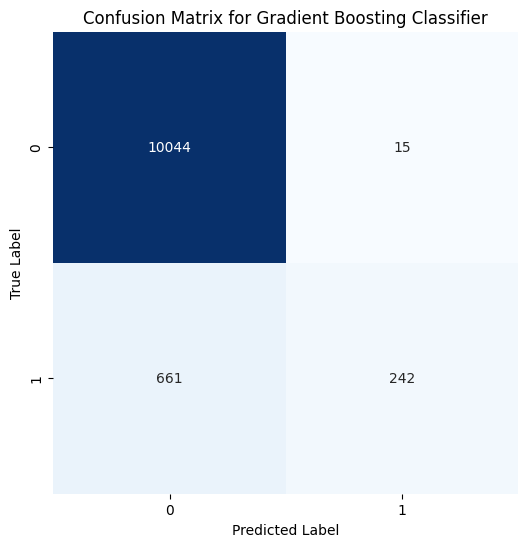

In [103]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Use appropriate classification metrics
     # Use appropriate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro", zero_division=1)
    recall = recall_score(y_test, y_pred,  average="macro", zero_division=1)
    f1 = f1_score(y_test, y_pred,  average="macro")

    # Calculate the confusion matrix with class labels
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm

# Initialize different classification models
models = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(

    )
}

# Specify your class labels (replace with your actual class labels)
# class_labels = ['0','1']

# Create a list to store the results
results = []
#  Parameters= {'ccp_alpha': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 132, 'subsample': 0.8, 'tol': 0.01, 'warm_start': False}

# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

# Print the results in a tabular form
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
print(tabulate(results, headers, tablefmt="grid"))

max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
# print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")

# Plot confusion matrix with class labels, emphasizing diagonals
plt.figure(figsize=(6, 6))
sns.heatmap(results[max_accuracy_index][-1], annot=True, fmt="d", cmap="Blues", cbar=False,  vmin=0, vmax=results[max_accuracy_index][-1].diagonal().max()+10)
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [106]:
y_test.value_counts()

0    10059
1      903
Name: is_promoted, dtype: int64

In [41]:
x_train1

,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,...,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
22770,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
17174,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
25924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
19407,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
29850,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23452,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
37135,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
27098,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [42]:
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [99]:

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
from sklearn.metrics import recall_score

model = GradientBoostingClassifier()

# Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': randint(50, 150),
    'max_depth': randint(3, 7),
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
random_search.fit(x_train1, y_train)

# Print the best parameters and corresponding recall
print("Best Parameters: ", random_search.best_params_)
print("Best Recall: ", random_search.best_score_)



Best Parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 124, 'subsample': 0.8}
Best Recall:  0.9141312774749547


In [59]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# Specify categorical and numerical features
categorical_features = X.select_dtypes(include="object")  # List of categorical feature column indices or names
numerical_features = X.select_dtypes(exclude="object")    # List of numerical feature column indices or names

# Create transformers
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
numerical_transformer = StandardScaler()

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])

# Assuming X is a DataFrame and y is a Series or array
kf = KFold(n_splits=5)
score = cross_val_score(model, X1, y, cv=kf)

# Print the cross-validated scores
print("Cross-validated Scores:", score)
print("Mean Accuracy:", score.mean())


Cross-validated Scores: [0.93203795 0.9408867  0.93769385 0.93531612 0.93449503]
Mean Accuracy: 0.9360859297782997


In [55]:
y.isna().sum()

0

In [57]:
categorical_columns = X.columns
features_to_encode = X[categorical_columns]

# Use pandas get_dummies to one-hot encode
X1 = pd.get_dummies(features_to_encode, drop_first=True)

In [58]:
X1

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,...,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,1,35,5.0,8,0,49.000000,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,1,30,5.0,4,0,60.000000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,34,3.0,7,0,50.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,2,39,1.0,10,0,50.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,45,3.0,2,0,73.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,1,48,3.0,17,0,78.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
54804,1,37,2.0,6,0,56.000000,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
54805,1,27,5.0,3,0,79.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
54806,1,29,1.0,2,0,63.712238,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [100]:
 Parameters= {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 124, 'subsample': 0.8}

In [101]:
Parameters

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 124,
 'subsample': 0.8}